<a href="https://colab.research.google.com/github/LukaszSzarecki/music-source-separation/blob/develop/ml_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nussl
!pip install scaper
import nussl
import matplotlib.pyplot as plt
import numpy as np

# Dataset - MUSDB18  i Scapper

### MUSDB18

Pobranie całego datasetu złożonego z 7 sekundowych klipów
Składa się na niego 150 tracków zawierających takie ścieżki

*   mixture.wav
* drums.wav
* bass.wav,
* other.wav,
* vocals.wav

100 utworów to dataset trenningowy, 50 utworów to dataset testowy


In [2]:
musdb = nussl.datasets.MUSDB18(download=True)
musdb_train = nussl.datasets.MUSDB18(subsets=['train'])
musdb_test = nussl.datasets.MUSDB18(subsets=['test'])


Done!


In [35]:

def show_sources(sources):
    if isinstance(sources, list):
        sources = {f'Source {i}': s for i, s in enumerate(sources)}
    plt.figure(figsize=(20, 10))
    nussl.core.utils.visualize_sources_as_waveform(sources)

    # plt.savefig('destination_path.eps', format='eps')
    plt.show()
    

Alexander Ross - Velvet Curtain


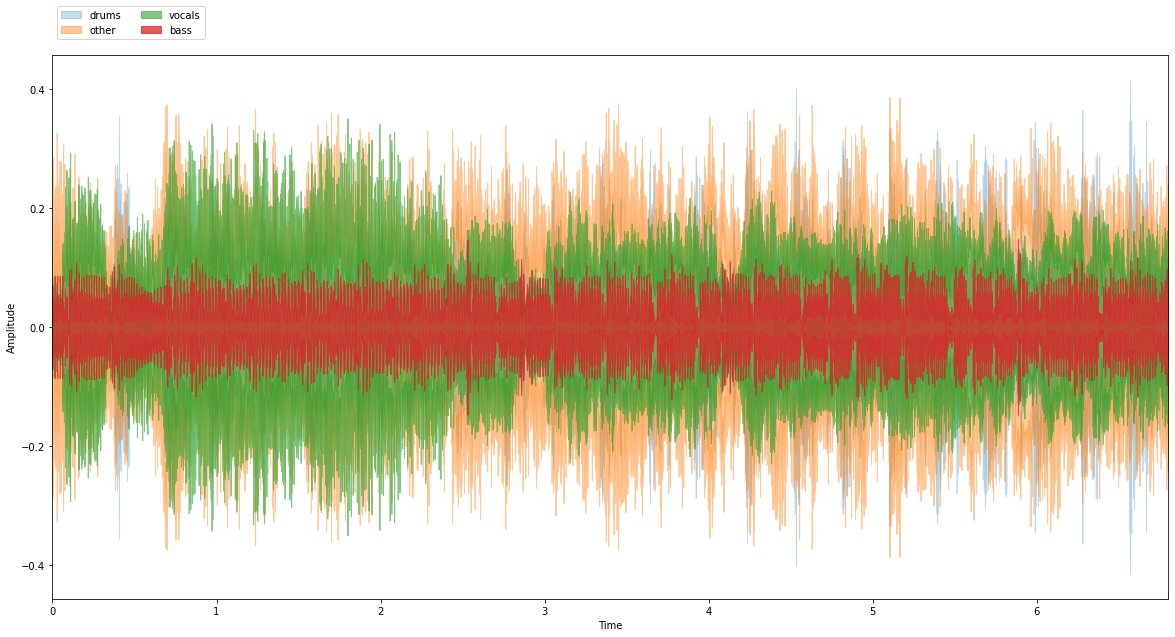

In [36]:
item = musdb[9]
mix = item['mix']
sources = item['sources']

print(item["mix"].file_name)
show_sources(item['sources'])

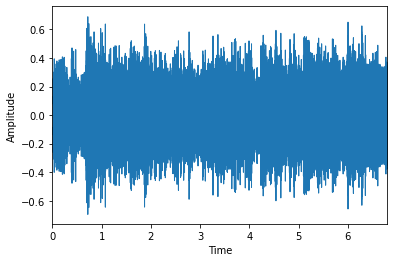

In [5]:
nussl.core.utils.visualize_waveform(mix)
plt.show()


## Scapper

### Zdefiniowanie Scapper 

W separacji dźwiękowej, Scapper oczekuje poniższej struktury:
```
foreground/
|--- drums/
     |--- stem.wav
|--- bass/
     |--- stem.wav
|--- vocals/
     |--- stem.wav
|--- other/
     |--- stem.wav
     
background/
(empty)

```

In [6]:
# Przygotowanie struktury plików
from pathlib import Path
from IPython.display import Audio, display


fg_folder = Path('~/.nussl/scapper_dataset/foreground').expanduser()  
fg_folder.mkdir(parents=True, exist_ok=True)   

for item in musdb_train:  
    song_name = item['mix'].file_name
    for key, val in item['sources'].items():
        src_path = fg_folder / key 
        src_path.mkdir(exist_ok=True)
        src_path = str(src_path / song_name) + '.wav'
        val.write_audio_to_file(src_path)





*   sr - częstotliwość próbkowania (sample rate) dla audio wyjsciowego
*   n_channels - liczba kanałów, czy audio będzie mono, czy stereo
*  ref_db  - głośność referencyjna wyrażona w dB dla audio wyjściowego



In [20]:
# Stworzenie template określajacego operacje wykonywane na ścieżkach audio
import scaper

template_event_parameters = {
    'label': ('const', 'vocals'),
    'source_file': ('choose', []),
    'source_time': ('uniform', 0, 7),
    'event_time': ('const', 0),
    'event_duration': ('const', 5.0),
    'snr': ('uniform', -5, 5),
    'pitch_shift': ('uniform', -3, 3),
    'time_stretch': ('uniform', 0.6, 1.4)
}

### Miks niespójny

In [10]:
def incoherent(fg_folder, bg_folder, event_template, seed):
    """
    This function takes the paths to the MUSDB18 source materials, an event template, 
    and a random seed, and returns an INCOHERENT mixture (audio + annotations). 
    
    Stems in INCOHERENT mixtures may come from different songs and are not temporally
    aligned.
    
    Parameters
    ----------
    fg_folder : str
        Path to the foreground source material for MUSDB18
    bg_folder : str
        Path to the background material for MUSDB18 (empty folder)
    event_template: dict
        Dictionary containing a template of probabilistic event parameters
    seed : int or np.random.RandomState()
        Seed for setting the Scaper object's random state. Different seeds will 
        generate different mixtures for the same source material and event template.
        
    Returns
    -------
    mixture_audio : np.ndarray
        Audio signal for the mixture
    mixture_jams : np.ndarray
        JAMS annotation for the mixture
    annotation_list : list
        Simple annotation in list format
    stem_audio_list : listf
        List containing the audio signals of the stems that comprise the mixture
    """
    
    # Create scaper object and seed random state
    sc = scaper.Scaper(
        duration=5.0,
        fg_path=str(fg_folder),
        bg_path=str(bg_folder),
        random_state=seed
    )
    
    # Set sample rate, reference dB, and channels (mono)
    sc.sr = 44100
    sc.ref_db = -20
    sc.n_channels = 1
    
    # Copy the template so we can change it
    event_parameters = event_template.copy()
    
    # Iterate over stem types and add INCOHERENT events
    labels = ['vocals', 'drums', 'bass', 'other']
    for label in labels:
        event_parameters['label'] = ('const', label)
        sc.add_event(**event_parameters)
    
    # Return the generated mixture audio + annotations 
    # while ensuring we prevent audio clipping
    return sc.generate(fix_clipping=True)




In [21]:
# Wygenerowanie 2 miksów z niepowiązanych ze sobą scieżek

# Do utrzymania porządku ignorujemy wszystkie warningi
import warnings
warnings.filterwarnings('ignore')

for seed in [1, 2]:
    
    mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(
        fg_folder, 
        fg_folder,
        template_event_parameters, 
        seed)
    
    display(Audio(data=mixture_audio.T, rate=44100))


### Miks spójny

In [14]:
def coherent(fg_folder, bg_folder, event_template, seed):
    """
    This function takes the paths to the MUSDB18 source materials and a random seed,
    and returns an COHERENT mixture (audio + annotations).
    
    Stems in COHERENT mixtures come from the same song and are temporally aligned.
    
    Parameters
    ----------
    fg_folder : str
        Path to the foreground source material for MUSDB18
    bg_folder : str
        Path to the background material for MUSDB18 (empty folder)
    event_template: dict
        Dictionary containing a template of probabilistic event parameters
    seed : int or np.random.RandomState()
        Seed for setting the Scaper object's random state. Different seeds will 
        generate different mixtures for the same source material and event template.
        
    Returns
    -------
    mixture_audio : np.ndarray
        Audio signal for the mixture
    mixture_jams : np.ndarray
        JAMS annotation for the mixture
    annotation_list : list
        Simple annotation in list format
    stem_audio_list : list
        List containing the audio signals of the stems that comprise the mixture
    """
        
    # Create scaper object and seed random state
    sc = scaper.Scaper(
        duration=5.0,
        fg_path=str(fg_folder),
        bg_path=str(bg_folder),
        random_state=seed
    )
    
    # Set sample rate, reference dB, and channels (mono)
    sc.sr = 44100
    sc.ref_db = -20
    sc.n_channels = 1
    
    # Copy the template so we can change it
    event_parameters = event_template.copy()    
    
    # Instatiate the template once to randomly choose a song,   
    # a start time for the sources, a pitch shift and a time    
    # stretch. These values must remain COHERENT across all stems
    sc.add_event(**event_parameters)
    event = sc._instantiate_event(sc.fg_spec[0])
    
    # Reset the Scaper object's the event specification
    sc.reset_fg_event_spec()
    
    # Replace the distributions for source time, pitch shift and 
    # time stretch with the constant values we just sampled, to  
    # ensure our added events (stems) are coherent.              
    event_parameters['source_time'] = ('const', event.source_time)
    event_parameters['pitch_shift'] = ('const', event.pitch_shift)
    event_parameters['time_stretch'] = ('const', event.time_stretch)

    # Iterate over the four stems (vocals, drums, bass, other) and 
    # add COHERENT events.                                         
    labels = ['vocals', 'drums', 'bass', 'other']
    for label in labels:
        
        # Set the label to the stem we are adding
        event_parameters['label'] = ('const', label)
        
        # To ensure coherent source files (all from the same song), we leverage
        # the fact that all the stems from the same song have the same filename.
        # All we have to do is replace the stem file's parent folder name from "vocals" 
        # to the label we are adding in this iteration of the loop, which will give the 
        # correct path to the stem source file for this current label.
        coherent_source_file = event.source_file.replace('vocals', label)
        event_parameters['source_file'] = ('const', coherent_source_file)
        # Add the event using the modified, COHERENT, event parameters
        sc.add_event(**event_parameters)
    
    # Generate and return the mixture audio, stem audio, and annotations
    return sc.generate(fix_clipping=True)

In [22]:
# Wygenerowanie 2 miksów z powiązamymi ze sobą scieżkami

# Do utrzymania porządku ignorujemy wszystkie warningi
import warnings
warnings.filterwarnings('ignore')

for seed in [1, 2]:
    
    mixture_audio, mixture_jam, annotation_list, stem_audio_list = coherent(
        fg_folder, 
        fg_folder,
        template_event_parameters, 
        seed)
    
    display(Audio(data=mixture_audio.T, rate=44100))

### Załączenie Scaper do nussl

In [26]:
import numpy as np

def generate_mixture(dataset, fg_folder, bg_folder, event_template, seed):
    
    data = coherent(fg_folder, bg_folder, event_template, seed)
            
    # unpack the data
    mixture_audio, mixture_jam, annotation_list, stem_audio_list = data
    
    # convert mixture to nussl format
    mix = dataset._load_audio_from_array(
        audio_data=mixture_audio, sample_rate=dataset.sample_rate
    )
    
    # convert stems to nussl format
    sources = {}
    ann = mixture_jam.annotations.search(namespace='scaper')[0]
    for obs, stem_audio in zip(ann.data, stem_audio_list):
        key = obs.value['label']
        sources[key] = dataset._load_audio_from_array(
            audio_data=stem_audio, sample_rate=dataset.sample_rate
        )
    
    # store the mixture, stems and JAMS annotation in the format expected by nussl
    output = {
        'mix': mix,
        'sources': sources,
        'metadata': mixture_jam
    }
    return output

In [27]:
class MixClosure:
    
    def __init__(self, fg_folder, bg_folder, event_template):
        self.fg_folder = fg_folder
        self.bg_folder = bg_folder
        self.event_template = event_template
        
    def __call__(self, dataset, seed):
        return generate_mixture(dataset, self.fg_folder, self.bg_folder, self.event_template, 123)
    
# Initialize our mixing function with our specific source material and event template
mix_func = MixClosure(fg_folder, fg_folder, template_event_parameters)

# Create a nussle OnTheFly data generator
on_the_fly = nussl.datasets.OnTheFly(
    num_mixtures=10,
    mix_closure=mix_func
)

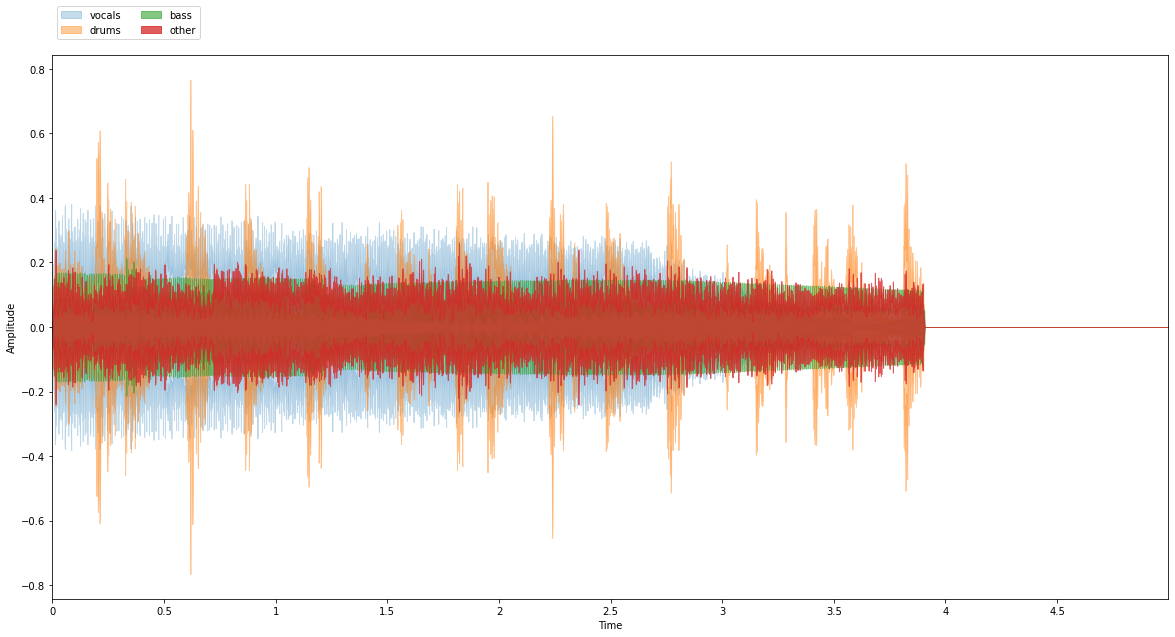

In [38]:
item = on_the_fly[5]
show_sources(item['sources'])



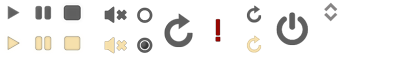
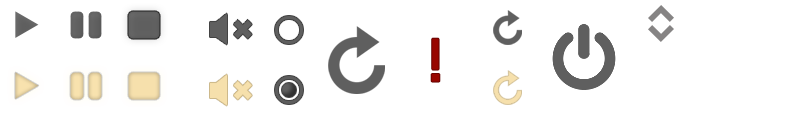
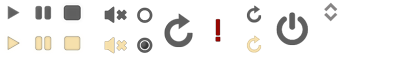

In [39]:
nussl.play_utils.multitrack(item['sources'])